## Install dependencies

In [17]:
import yfinance as yf
print(yf.__version__)

0.2.61


In [18]:
import pandas as pd
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
import torch

# # Set up device for GPU acceleration
# device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using device: {device}")

# # Move models to the appropriate device
# torch.set_default_device(device)

## Stage 1: Preprocessing

In [19]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime

from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.config import INDICATORS

import itertools

In [20]:
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=600)

start_date = start_date.strftime("%Y-%m-%d")
end_date = end_date.strftime("%Y-%m-%d")

print("Start date: ", start_date)
print("End date: ", end_date)

Start date:  2023-10-15
End date:  2025-06-06


In [21]:
# Download NVDA hourly data
nvda_df_yf = yf.download(
    tickers="NVDA",
    start=start_date,
    end=end_date,
    interval="1h",
)

# Reset index and add 'tic' column for FinRL compatibility
nvda_df_yf.columns = nvda_df_yf.columns.get_level_values(0)   #flatten multi-index columns
nvda_df_yf.reset_index(inplace=True) # ensure consistent index
nvda_df_yf.rename(columns={'Datetime': 'date'}, inplace=True)  # rename 'Datetime' to 'date' finr rl requires 'date' column
nvda_df_yf['tic'] = 'NVDA' # add ticker column for FinRL compatibility

# Reorder and rename columns to lowercase
nvda_df_yf = nvda_df_yf.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})

# Add a column for the day of the week (0 = Monday, 6 = Sunday)
nvda_df_yf['day'] = nvda_df_yf['date'].dt.dayofweek

# Optionally filter out weekends (since the market is closed)
nvda_df_yf = nvda_df_yf[nvda_df_yf['day'] < 5]


# Keep only needed columns for FinRL
nvda_df_yf = nvda_df_yf[['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day']]

nvda_df_yf.head()

[*********************100%***********************]  1 of 1 completed


Price,date,open,high,low,close,volume,tic,day
0,2023-10-16 13:30:00+00:00,45.063000,46.041611,44.911999,46.017498,12269008,NVDA,0
1,2023-10-16 14:30:00+00:00,46.021999,46.125141,45.774010,46.047001,5512241,NVDA,0
2,2023-10-16 15:30:00+00:00,46.048000,46.224998,45.731102,45.877998,4372176,NVDA,0
3,2023-10-16 16:30:00+00:00,45.885990,46.058990,45.507999,45.652000,3717098,NVDA,0
4,2023-10-16 17:30:00+00:00,45.654999,45.994987,45.596001,45.894501,3247660,NVDA,0


### TURBULANCE CHECKKKKK

•	I want to give the agent higher-level market regime context (e.g., “Are we in a volatile day?”).
•	We are combining daily macro risk (via turbulence) with hourly micro risk (e.g., news-based sentiment score).
•	We are dealing with single-asset hourly data and don’t want to compute Mahalanobis distances at the hourly level (which would be meaningless or numerically unstable).

In this setup:

The turbulence score acts like a regime signal, while the sentiment score acts like an asset-specific signal.

That’s a other architectural move to test.

In [22]:
##  Downsample hourly NVDA data to daily

# Resample your hourly data to daily OHLCV
daily_df = nvda_df_yf.resample('1D', on='date').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
    'tic': 'first'
}).dropna().reset_index()

In [23]:
# compute daily returns
# Note: pct_change() will return NaN for the first row since there's no previous value to compare
daily_df['return'] = daily_df['close'].pct_change()

daily_df

Price,date,open,high,low,close,volume,tic,return
0,2023-10-16 00:00:00+00:00,45.063000,46.224998,44.911999,46.088001,35120972,NVDA,NaN
1,2023-10-17 00:00:00+00:00,44.000000,44.754002,42.480000,43.954998,78684453,NVDA,-0.046281
2,2023-10-18 00:00:00+00:00,42.591000,43.219002,41.825001,42.196999,60131394,NVDA,-0.039995
3,2023-10-19 00:00:00+00:00,42.810997,43.297001,41.882000,42.084000,47075221,NVDA,-0.002678
4,2023-10-20 00:00:00+00:00,41.889999,42.470001,41.077999,41.374001,45028106,NVDA,-0.016871
...,...,...,...,...,...,...,...,...
406,2025-05-30 00:00:00+00:00,138.729996,139.610001,132.919998,134.839996,267611964,NVDA,-0.031183
407,2025-06-02 00:00:00+00:00,135.539993,138.119995,135.419998,137.369995,163531942,NVDA,0.018763
408,2025-06-03 00:00:00+00:00,138.779999,142.000000,137.955002,141.270004,197819449,NVDA,0.028391
409,2025-06-04 00:00:00+00:00,142.220001,142.389999,139.544998,141.830093,150819354,NVDA,0.003965


In [24]:
# lets define our own turbulance function
import numpy as np
import pandas as pd
from scipy.stats import zscore

def calculate_turbulence(df, lookback=20): #lookback period for historical returns, its our wwindow size
    turbulence_index = [0] * lookback  # NaNs or zeros for warmup
    
    for i in range(lookback, len(df)):
        hist_returns = df['return'].iloc[i - lookback:i]
        current_return = df['return'].iloc[i]
        
        # If there’s not enough variance, skip to avoid division by zero
        if hist_returns.std() == 0:
            turbulence_index.append(0)
            continue

        # Z-score based turbulence approximation (simplified Mahalanobis for univariate)
        z = (current_return - hist_returns.mean()) / hist_returns.std()
        turbulence_index.append(z ** 2)  # Squared z-score

    df['turbulence'] = turbulence_index
    return df



This function gives a proxy for Mahalanobis distance in a univariate setting (which is fine for single-asset NVDA).
If you expand to multi-asset, you’ll want to compute the full covariance matrix and use scipy.spatial.distance.mahalanobis.

In [25]:
daily_df = calculate_turbulence(daily_df)

#check high in stable days
stable_days = daily_df[daily_df['turbulence'] < 0.1]
print("Stable days count:", len(stable_days))
# Check high in turbulent days
turbulent_days = daily_df[daily_df['turbulence'] >= 0.1]
print("Turbulent days count:", len(turbulent_days))

#order from high turbulance days  to low turbulance days
turbulent_days_sorted = turbulent_days.sort_values(by='turbulence', ascending=False)
turbulent_days_sorted

#order from returns high to low
turbulent_days_sorted = turbulent_days.sort_values(by='return', ascending=False)
turbulent_days_sorted.head(10)

Stable days count: 119
Turbulent days count: 292


Price,date,open,high,low,close,volume,tic,return,turbulence
371,2025-04-09 00:00:00+00:00,98.879997,115.099998,97.530098,114.250000,542958179,NVDA,0.181367,25.505338
88,2024-02-22 00:00:00+00:00,74.800003,78.574997,74.220001,78.527000,81032358,NVDA,0.163449,38.770236
198,2024-07-31 00:00:00+00:00,112.900002,118.339996,110.879997,117.169998,406933929,NVDA,0.129811,14.938846
152,2024-05-23 00:00:00+00:00,102.000000,106.319992,101.520004,103.820999,79326705,NVDA,0.094350,11.359151
321,2025-01-28 00:00:00+00:00,121.805000,129.000000,116.250000,128.980103,537185083,NVDA,0.088348,3.984654
227,2024-09-11 00:00:00+00:00,109.500000,117.180000,107.601196,116.849998,403446311,NVDA,0.081744,4.184387
101,2024-03-12 00:00:00+00:00,88.048996,91.959999,86.150101,91.938004,62134457,NVDA,0.071638,1.908113
154,2024-05-28 00:00:00+00:00,110.228004,114.939003,109.887001,114.000000,60810106,NVDA,0.071046,4.359459
173,2024-06-25 00:00:00+00:00,121.199997,126.500000,119.320000,126.250000,375279069,NVDA,0.069281,3.253148
204,2024-08-08 00:00:00+00:00,101.989998,105.500000,97.519997,105.220001,356872210,NVDA,0.065519,2.584121


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

We’ll measure the relationship between turbulence level and future return, to see whether high turbulence corresponds to:


	•	More opportunity (high absolute returns)
	•	More danger (high volatility and negative returns)

In [27]:
daily_df['turbulence_bin'] = pd.qcut(daily_df['turbulence'], q=5, labels=False) # create 5 bins for turbulence

# THIS MEANS WE HAVE 5 CATEGORIES OF TURBULANCE 
# 0: Very Low Turbulence
# 1: Low Turbulence
# 2: Medium Turbulence
# 3: High Turbulence
# 4: Very High Turbulence


In [28]:
# conpute avg returns for each turbulence bin and returns

grouped = daily_df.groupby('turbulence_bin').agg({
    'return': ['mean', 'std', 'count']
})
grouped.columns = ['avg_return', 'volatility', 'samples']
grouped.reset_index(inplace=True)

print(grouped)


   turbulence_bin  avg_return  volatility  samples
0               0    0.003655    0.014292       82
1               1    0.000251    0.013836       82
2               2    0.006204    0.023044       82
3               3    0.003520    0.032655       82
4               4    0.002870    0.062839       82


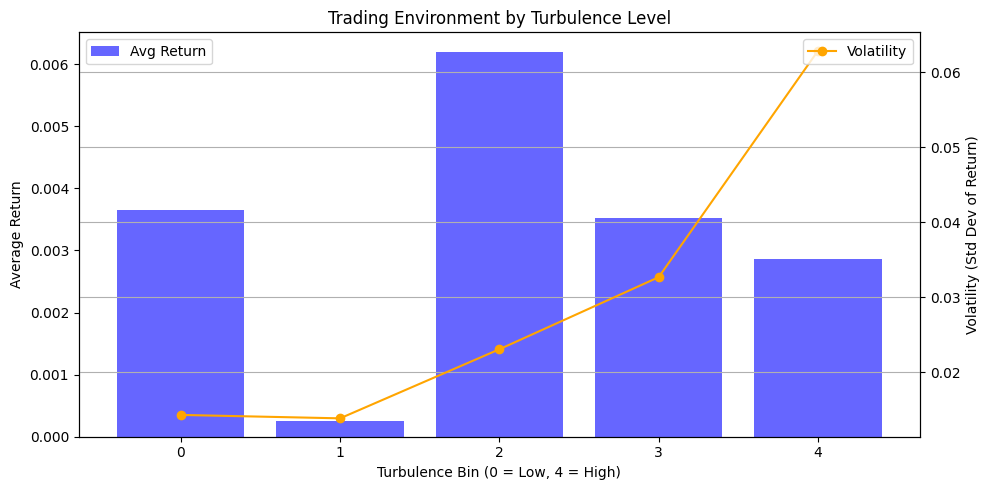

In [29]:
# visualize average returns for each turbulence bin

fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

ax1.bar(grouped['turbulence_bin'], grouped['avg_return'], color='blue', alpha=0.6, label='Avg Return')
ax2.plot(grouped['turbulence_bin'], grouped['volatility'], color='orange', label='Volatility', marker='o')

ax1.set_xlabel('Turbulence Bin (0 = Low, 4 = High)')
ax1.set_ylabel('Average Return')
ax2.set_ylabel('Volatility (Std Dev of Return)')
plt.title('Trading Environment by Turbulence Level')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig("return_vs_volatility_by_turbulence.png")
plt.show()

🧠 Key Observations

1. 📈 Returns peak in mid-turbulence (Bin 2–3)
	•	This is textbook “volatility sweet spot”:
	•	Enough price movement to create opportunities
	•	Not so chaotic that signal breaks down
	•	This is often where momentum and mean-reversion strategies thrive

2. 🚨 High turbulence (Bin 4) has lower average return and highest volatility
	•	This suggests that during market stress, returns become more random and risk spikes
	•	You’re likely seeing whipsaws, false breakouts, and irrational volatility
	•	Implication: trading aggressively in Bin 4 is dangerous

3. 💤 Lowest turbulence (Bin 0–1) has low return and low volatility
	•	These are likely sideways markets or tight consolidation
	•	Good environment for low-risk carry or market-making, but not for high-risk directional trades

lets prepare a strategy with tirbulance 

and lets modify our reward function with this
so our prime trading times will be 2,3 with high avg return

reward -= penalty * (turbulence > high_threshold)

